# CC's LSTM for stock prediction

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

## Hyper parameters

In [ ]:
#reduce feature number
#batch size from 32 to 8


In [18]:
# for dataset splitting
TRAIN_RATIO = 8
VALIDATION_RATIO = 1
TEST_RATIO = 1

# Using previous 60 days data to predict next 7 days close price
## time window size
TIME_WINDOW_SIZE = 60
## feature size
NFEATURES = 33
## forescast size
FORECAST_SIZE = 5

# Model related parameters
BATCH_SIZE = 8 # for LSTM, don't use large batch_size
EPOCH = 250

# Train related parameters
MODEL_SAVED_PATH = "./saved_model/exp_11/"
init_epoch = 0

## Load dataset from csv and split train, validation and test dataset (8:1:1)

In [ ]:
dataset_df1 = pd.read_csv("./data/new_dataset.csv")

# dataset_df = dataset1.drop(columns={'Dividends','Stock Splits'})
# dataset_df

In [ ]:
dataset_df = dataset_df1.drop(columns={'Dividends','Stock Splits','Unnamed: 0','Date'})

In [ ]:
dataset_df

In [ ]:
dataset_df = dataset_df.drop(columns={'AMZ_Volume','Apple_Volume','SP_Volume','GOOG_Volume','MS_Volume','ORC_Volume'})
dataset_df

In [ ]:
# transfer pandas dataframe to numpy ndarray
dataset_np = np.array(dataset_df.iloc[:, 0:])
dataset_np.shape

In [ ]:
# dataset_df = dataset_df.drop(columns=['Unnamed: 0', 'Date'])
# dataset_df

In [ ]:
# split train, validation and test
dataset_size = dataset_np.shape[0]
dataset_segment = dataset_size // 10
train_dataset = dataset_np[:TRAIN_RATIO * dataset_segment]
validation_dataset = dataset_np[TRAIN_RATIO * dataset_segment: (TRAIN_RATIO + VALIDATION_RATIO) * dataset_segment]
test_dataset = dataset_np[(TRAIN_RATIO + VALIDATION_RATIO) * dataset_segment:]

train_dataset.shape, validation_dataset.shape, test_dataset.shape

### save dataset to file

In [ ]:
dataset_pickle_folder = "./data/pickles"
train_set_filename = "train_set.pk"
valid_set_filename = "valid_set.pk"
test_set_filename = "test_set.pk"

train_set_path = os.path.join(dataset_pickle_folder, train_set_filename)
valid_set_path = os.path.join(dataset_pickle_folder, valid_set_filename)
test_set_path = os.path.join(dataset_pickle_folder, test_set_filename)

with open(train_set_path, "wb") as fp:
    pickle.dump(train_dataset, fp)

with open(valid_set_path, "wb") as fp:
    pickle.dump(validation_dataset, fp)

with open(test_set_path, "wb") as fp:
    pickle.dump(test_dataset, fp)

print("Done")

### load dataset from file (starts here)

In [5]:
dataset_pickle_folder = "./data/pickles"
train_set_filename = "train_set.pk"
valid_set_filename = "valid_set.pk"
test_set_filename = "test_set.pk"

train_set_path = os.path.join(dataset_pickle_folder, train_set_filename)
valid_set_path = os.path.join(dataset_pickle_folder, valid_set_filename)
test_set_path = os.path.join(dataset_pickle_folder, test_set_filename)

with open(train_set_path, "rb") as fp:
    train_dataset = pickle.load(fp)

with open(valid_set_path, "rb") as fp:
    validation_dataset = pickle.load(fp)

with open(test_set_path, "rb") as fp:
    test_dataset = pickle.load(fp)

train_dataset.shape, validation_dataset.shape, test_dataset.shape

((2008, 33), (251, 33), (258, 33))

In [7]:
dataset_df

NameError: name 'dataset_df' is not defined

## Define data normalization function

In [8]:
def normalize_by_column_within_time_window(x, y):
  # x.shape = (window_size, 40)
  # y.shape = (forecast_size)
  EPS = 1e-5
  ret_x = np.array(x)
  ret_y = np.array(y)

  train_close_price_min = np.min(ret_x[:, 32]) # the 38th column of x is the log_diff
  train_close_price_max = np.max(ret_x[:, 32])

  for i in range(ret_x.shape[1]):
    column_min = np.min(ret_x[:, i])
    column_max = np.max(ret_x[:, i])
#     print("debug:", i, column_min, column_max)
    ret_x[:, i] = (ret_x[:, i] - column_min) / (column_max - column_min + EPS)  # EPS for value stability (x / 0.000000000000000001 will be huge)

  
  ret_y = (ret_y - train_close_price_min) / (train_close_price_max - train_close_price_min + EPS)
  
  return ret_x, ret_y

In [ ]:
# # fix every column into [0, 1)
# train_data_norm = normalize_by_column(train_dataset)
# validation_dataset_norm = normalize_by_column(validation_dataset)
# test_dataset_norm = normalize_by_column(test_dataset)

In [ ]:
# np.min(train_data_norm[:, 0]), np.max(train_data_norm[:, 0])

## Define Kears data generator (keras.utils.Sequence)

In [9]:
class DataGenerator(tf.keras.utils.Sequence):

  def __init__(self, dataset, batch_size, window_size, forecast_size, shuffle=False):
    self.dataset = dataset  # shape = (n, features)
    self.batch_size = batch_size
    self.window_size = window_size
    self.forecast_size = forecast_size

    self.x = []             # final x.shape = (-1, window_size, features)
    self.y = []             # final y.shape = (-1, forecast_size)
    for i in range(self.dataset.shape[0] - window_size - forecast_size):
      # cur_x: dataset[i: i + window_size], shape = (window_size, nfeatures)
      # cur_y: dataset[i + window_size: i + window_size + forecast_size, 3], shape = shape = (window_size, 1)
      # normalize_by_column_within_time_window fix x and y to around [0, 1]
      cur_x, cur_y = normalize_by_column_within_time_window(dataset[i: i + window_size, :], dataset[i + window_size: i + window_size + forecast_size, 32].reshape(-1, forecast_size))

      # cur_x = dataset[i: i + window_size, :]
      # cur_y = dataset[i + window_size: i + window_size + forecast_size, 3]

      self.x.append(cur_x)
      self.y.append(cur_y)
      
    self.x = np.array(self.x)
    self.y = np.array(self.y).reshape(-1, forecast_size)
    
    if shuffle:
      shuffle_idx = np.random.permutation(self.x.shape[0])
      self.x = self.x[shuffle_idx, :, :]
      self.y = self.y[shuffle_idx, :]

  def __len__(self):
    return self.x.shape[0] // self.batch_size

  def __getitem__(self, idx):
    # return one batch data 
    # x: (batch_size, window_size, features)
    # y: (batch_size, forecast_size, 1)
    batch_x = self.x[idx * self.batch_size: (idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size: (idx + 1) * self.batch_size]

    return batch_x, batch_y

In [10]:
train_gen = DataGenerator(dataset=train_dataset, batch_size=BATCH_SIZE, window_size=TIME_WINDOW_SIZE, forecast_size=FORECAST_SIZE, shuffle=True)
valid_gen = DataGenerator(dataset=validation_dataset, batch_size=BATCH_SIZE, window_size=TIME_WINDOW_SIZE, forecast_size=FORECAST_SIZE, shuffle=False)
test_gen = DataGenerator(dataset=test_dataset, batch_size=BATCH_SIZE, window_size=TIME_WINDOW_SIZE, forecast_size=FORECAST_SIZE, shuffle=False)

In [11]:
train_batch_x, train_batch_y = train_gen[0]
train_batch_x.shape, train_batch_y.shape
# should be (batch, window_size, nfeatures) and (batch, forecast_size)

((8, 60, 33), (8, 5))

In [12]:
train_batch_y[0]

array([0.72823489, 0.42848701, 0.5436577 , 0.7867314 , 0.47972117])

## Define sequential model and train related stuff

In [13]:
class LSTMPredictor(keras.Model):

  def __init__(self, input_shape, forecast_size): 
    # input shape should be (batch, window_size, features)
    super().__init__()

    self.lstm1 = keras.layers.LSTM(10, activation="sigmoid", input_shape=input_shape, return_sequences=True)  # (batch, window_size, 10)
    self.dropout1 = keras.layers.Dropout(0.1)

    self.lstm2 = keras.layers.LSTM(32, activation="sigmoid", return_sequences=True) # (batch, window_size, 32)
    self.dropout2 = keras.layers.Dropout(0.1)

    self.lstm3 = keras.layers.LSTM(64, activation="sigmoid", return_sequences=True) # (batch, window_size, 64)
    self.dropout3 = keras.layers.Dropout(0.1)

    self.lstm4 = keras.layers.LSTM(32, activation="sigmoid", return_sequences=True) # (batch, window_size, 32)
    self.dropout4 = keras.layers.Dropout(0.1)

    self.lstm5 = keras.layers.LSTM(forecast_size, activation="relu", return_sequences=False) # (batch, forecast_size)
    self.dense5 = keras.layers.Dense(forecast_size) # (batch, forecast_size)
  
  def call(self, inputs):
    x = self.lstm1(inputs)
    x = self.dropout1(x)
    x = self.lstm2(x)
    x = self.dropout2(x)
    x = self.lstm3(x)
    x = self.dropout3(x)
    x = self.lstm4(x)
    x = self.dropout4(x)

    x = self.lstm5(x)
    x = self.dense5(x)
    return x

In [15]:
model = LSTMPredictor(input_shape=(-1, TIME_WINDOW_SIZE, NFEATURES), forecast_size=FORECAST_SIZE)

# optimizer
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
# sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

model.compile(optimizer=adam, loss="mse", metrics=["mape"])
model.build(input_shape=(BATCH_SIZE, TIME_WINDOW_SIZE, NFEATURES))
model.summary()

Model: "lstm_predictor_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               multiple                  1760      
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 lstm_6 (LSTM)               multiple                  5504      
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 lstm_7 (LSTM)               multiple                  24832     
                                                                 
 dropout_6 (Dropout)         multiple                  0         
                                                                 
 lstm_8 (LSTM)               multiple             

In [16]:
# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath=MODEL_SAVED_PATH + 'LSTM_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename=MODEL_SAVED_PATH + 'LSTM_training_log.csv',
                       separator=',',
                       append=True)

def lr_schedule(epoch):
    if epoch < 100:
        return 0.001
    elif epoch < 200:
        return 0.0001
    else:
        return 0.00001

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

## Train

In [ ]:
!ls

In [19]:
history = model.fit(train_gen, 
                    epochs=EPOCH,
                    validation_data=valid_gen,
                    callbacks=callbacks,
                    initial_epoch=init_epoch);


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/250
242/242 [==============================] - ETA: 0s - loss: 0.1635 - mape: 158.7449
Epoch 1: val_loss improved from inf to 0.07428, saving model to ./saved_model/exp_11/LSTM_epoch-01_loss-0.1635_val_loss-0.0743.h5
242/242 [==============================] - 25s 104ms/step - loss: 0.1635 - mape: 158.7449 - val_loss: 0.0743 - val_mape: 77.3297 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/250
242/242 [==============================] - ETA: 0s - loss: 0.0827 - mape: 231.4076
Epoch 2: val_loss improved from 0.07428 to 0.04240, saving model to ./saved_model/exp_11/LSTM_epoch-02_loss-0.0827_val_loss-0.0424.h5
242/242 [==============================] - 24s 101ms/step - loss: 0.0827 - mape: 231.4076 - val_loss: 0.0424 - val_mape: 75.0985 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/250
242/242 [==============================] - ETA: 0s - loss:

242/242 [==============================] - 24s 99ms/step - loss: 0.0433 - mape: 246.7041 - val_loss: 0.0359 - val_mape: 66.7002 - lr: 0.0010

Epoch 23: LearningRateScheduler setting learning rate to 0.001.
Epoch 23/250
242/242 [==============================] - ETA: 0s - loss: 0.0433 - mape: 248.9781
Epoch 23: val_loss did not improve from 0.03392
242/242 [==============================] - 24s 99ms/step - loss: 0.0433 - mape: 248.9781 - val_loss: 0.0341 - val_mape: 70.1388 - lr: 0.0010

Epoch 24: LearningRateScheduler setting learning rate to 0.001.
Epoch 24/250
242/242 [==============================] - ETA: 0s - loss: 0.0430 - mape: 246.7540
Epoch 24: val_loss did not improve from 0.03392
242/242 [==============================] - 25s 102ms/step - loss: 0.0430 - mape: 246.7540 - val_loss: 0.0341 - val_mape: 72.9528 - lr: 0.0010

Epoch 25: LearningRateScheduler setting learning rate to 0.001.
Epoch 25/250
242/242 [==============================] - ETA: 0s - loss: 0.0433 - mape: 246.94


Epoch 46: LearningRateScheduler setting learning rate to 0.001.
Epoch 46/250
242/242 [==============================] - ETA: 0s - loss: 0.0422 - mape: 242.5898
Epoch 46: val_loss did not improve from 0.03367
242/242 [==============================] - 24s 99ms/step - loss: 0.0422 - mape: 242.5898 - val_loss: 0.0345 - val_mape: 74.5098 - lr: 0.0010

Epoch 47: LearningRateScheduler setting learning rate to 0.001.
Epoch 47/250
242/242 [==============================] - ETA: 0s - loss: 0.0425 - mape: 242.8541
Epoch 47: val_loss did not improve from 0.03367
242/242 [==============================] - 24s 99ms/step - loss: 0.0425 - mape: 242.8541 - val_loss: 0.0346 - val_mape: 67.2603 - lr: 0.0010

Epoch 48: LearningRateScheduler setting learning rate to 0.001.
Epoch 48/250
242/242 [==============================] - ETA: 0s - loss: 0.0425 - mape: 243.1838
Epoch 48: val_loss did not improve from 0.03367
242/242 [==============================] - 24s 100ms/step - loss: 0.0425 - mape: 243.1838 -

Epoch 69/250
242/242 [==============================] - ETA: 0s - loss: 0.0421 - mape: 246.2729
Epoch 69: val_loss did not improve from 0.03358
242/242 [==============================] - 24s 99ms/step - loss: 0.0421 - mape: 246.2729 - val_loss: 0.0355 - val_mape: 65.8966 - lr: 0.0010

Epoch 70: LearningRateScheduler setting learning rate to 0.001.
Epoch 70/250
242/242 [==============================] - ETA: 0s - loss: 0.0420 - mape: 244.1676
Epoch 70: val_loss did not improve from 0.03358
242/242 [==============================] - 24s 99ms/step - loss: 0.0420 - mape: 244.1676 - val_loss: 0.0343 - val_mape: 73.4660 - lr: 0.0010

Epoch 71: LearningRateScheduler setting learning rate to 0.001.
Epoch 71/250
242/242 [==============================] - ETA: 0s - loss: 0.0419 - mape: 240.7199
Epoch 71: val_loss did not improve from 0.03358
242/242 [==============================] - 24s 100ms/step - loss: 0.0419 - mape: 240.7199 - val_loss: 0.0338 - val_mape: 68.5568 - lr: 0.0010

Epoch 72: Lea

242/242 [==============================] - 25s 103ms/step - loss: 0.0415 - mape: 233.4931 - val_loss: 0.0371 - val_mape: 79.9427 - lr: 0.0010

Epoch 92: LearningRateScheduler setting learning rate to 0.001.
Epoch 92/250
242/242 [==============================] - ETA: 0s - loss: 0.0416 - mape: 236.6346
Epoch 92: val_loss did not improve from 0.03329
242/242 [==============================] - 25s 102ms/step - loss: 0.0416 - mape: 236.6346 - val_loss: 0.0338 - val_mape: 67.7156 - lr: 0.0010

Epoch 93: LearningRateScheduler setting learning rate to 0.001.
Epoch 93/250
242/242 [==============================] - ETA: 0s - loss: 0.0414 - mape: 234.8014
Epoch 93: val_loss did not improve from 0.03329
242/242 [==============================] - 25s 102ms/step - loss: 0.0414 - mape: 234.8014 - val_loss: 0.0362 - val_mape: 65.2377 - lr: 0.0010

Epoch 94: LearningRateScheduler setting learning rate to 0.001.
Epoch 94/250
242/242 [==============================] - ETA: 0s - loss: 0.0413 - mape: 242.


Epoch 115: LearningRateScheduler setting learning rate to 0.0001.
Epoch 115/250
242/242 [==============================] - ETA: 0s - loss: 0.0405 - mape: 235.4769
Epoch 115: val_loss did not improve from 0.03329
242/242 [==============================] - 25s 102ms/step - loss: 0.0405 - mape: 235.4769 - val_loss: 0.0336 - val_mape: 68.0315 - lr: 1.0000e-04

Epoch 116: LearningRateScheduler setting learning rate to 0.0001.
Epoch 116/250
242/242 [==============================] - ETA: 0s - loss: 0.0406 - mape: 238.5082
Epoch 116: val_loss did not improve from 0.03329
242/242 [==============================] - 25s 103ms/step - loss: 0.0406 - mape: 238.5082 - val_loss: 0.0334 - val_mape: 68.9763 - lr: 1.0000e-04

Epoch 117: LearningRateScheduler setting learning rate to 0.0001.
Epoch 117/250
242/242 [==============================] - ETA: 0s - loss: 0.0407 - mape: 238.4074
Epoch 117: val_loss did not improve from 0.03329
242/242 [==============================] - 24s 100ms/step - loss: 0.0


Epoch 138: LearningRateScheduler setting learning rate to 0.0001.
Epoch 138/250
242/242 [==============================] - ETA: 0s - loss: 0.0405 - mape: 236.6103
Epoch 138: val_loss did not improve from 0.03329
242/242 [==============================] - 24s 101ms/step - loss: 0.0405 - mape: 236.6103 - val_loss: 0.0339 - val_mape: 67.1829 - lr: 1.0000e-04

Epoch 139: LearningRateScheduler setting learning rate to 0.0001.
Epoch 139/250
242/242 [==============================] - ETA: 0s - loss: 0.0406 - mape: 237.5648
Epoch 139: val_loss did not improve from 0.03329
242/242 [==============================] - 24s 100ms/step - loss: 0.0406 - mape: 237.5648 - val_loss: 0.0339 - val_mape: 67.2090 - lr: 1.0000e-04

Epoch 140: LearningRateScheduler setting learning rate to 0.0001.
Epoch 140/250
242/242 [==============================] - ETA: 0s - loss: 0.0405 - mape: 237.2095
Epoch 140: val_loss did not improve from 0.03329
242/242 [==============================] - 25s 102ms/step - loss: 0.0


Epoch 161: LearningRateScheduler setting learning rate to 0.0001.
Epoch 161/250
242/242 [==============================] - ETA: 0s - loss: 0.0403 - mape: 235.6640
Epoch 161: val_loss did not improve from 0.03329
242/242 [==============================] - 24s 100ms/step - loss: 0.0403 - mape: 235.6640 - val_loss: 0.0339 - val_mape: 67.1958 - lr: 1.0000e-04

Epoch 162: LearningRateScheduler setting learning rate to 0.0001.
Epoch 162/250
242/242 [==============================] - ETA: 0s - loss: 0.0405 - mape: 234.5395
Epoch 162: val_loss did not improve from 0.03329
242/242 [==============================] - 25s 101ms/step - loss: 0.0405 - mape: 234.5395 - val_loss: 0.0340 - val_mape: 66.8739 - lr: 1.0000e-04

Epoch 163: LearningRateScheduler setting learning rate to 0.0001.
Epoch 163/250
242/242 [==============================] - ETA: 0s - loss: 0.0404 - mape: 234.6426
Epoch 163: val_loss did not improve from 0.03329
242/242 [==============================] - 24s 101ms/step - loss: 0.0


Epoch 184: LearningRateScheduler setting learning rate to 0.0001.
Epoch 184/250
242/242 [==============================] - ETA: 0s - loss: 0.0404 - mape: 235.1985
Epoch 184: val_loss did not improve from 0.03329
242/242 [==============================] - 24s 100ms/step - loss: 0.0404 - mape: 235.1985 - val_loss: 0.0340 - val_mape: 66.9975 - lr: 1.0000e-04

Epoch 185: LearningRateScheduler setting learning rate to 0.0001.
Epoch 185/250
242/242 [==============================] - ETA: 0s - loss: 0.0403 - mape: 233.7322
Epoch 185: val_loss did not improve from 0.03329
242/242 [==============================] - 25s 102ms/step - loss: 0.0403 - mape: 233.7322 - val_loss: 0.0339 - val_mape: 67.3546 - lr: 1.0000e-04

Epoch 186: LearningRateScheduler setting learning rate to 0.0001.
Epoch 186/250
242/242 [==============================] - ETA: 0s - loss: 0.0403 - mape: 232.0278
Epoch 186: val_loss did not improve from 0.03329
242/242 [==============================] - 25s 103ms/step - loss: 0.0


Epoch 207: LearningRateScheduler setting learning rate to 1e-05.
Epoch 207/250
242/242 [==============================] - ETA: 0s - loss: 0.0402 - mape: 235.8580
Epoch 207: val_loss did not improve from 0.03329
242/242 [==============================] - 24s 101ms/step - loss: 0.0402 - mape: 235.8580 - val_loss: 0.0341 - val_mape: 67.0229 - lr: 1.0000e-05

Epoch 208: LearningRateScheduler setting learning rate to 1e-05.
Epoch 208/250
242/242 [==============================] - ETA: 0s - loss: 0.0402 - mape: 230.6023
Epoch 208: val_loss did not improve from 0.03329
242/242 [==============================] - 24s 101ms/step - loss: 0.0402 - mape: 230.6023 - val_loss: 0.0341 - val_mape: 66.9338 - lr: 1.0000e-05

Epoch 209: LearningRateScheduler setting learning rate to 1e-05.
Epoch 209/250
242/242 [==============================] - ETA: 0s - loss: 0.0403 - mape: 234.9088
Epoch 209: val_loss did not improve from 0.03329
242/242 [==============================] - 25s 102ms/step - loss: 0.0403


Epoch 230: LearningRateScheduler setting learning rate to 1e-05.
Epoch 230/250
242/242 [==============================] - ETA: 0s - loss: 0.0402 - mape: 232.9442
Epoch 230: val_loss did not improve from 0.03329
242/242 [==============================] - 24s 99ms/step - loss: 0.0402 - mape: 232.9442 - val_loss: 0.0342 - val_mape: 66.7742 - lr: 1.0000e-05

Epoch 231: LearningRateScheduler setting learning rate to 1e-05.
Epoch 231/250
242/242 [==============================] - ETA: 0s - loss: 0.0402 - mape: 231.8292
Epoch 231: val_loss did not improve from 0.03329
242/242 [==============================] - 24s 99ms/step - loss: 0.0402 - mape: 231.8292 - val_loss: 0.0341 - val_mape: 66.9579 - lr: 1.0000e-05

Epoch 232: LearningRateScheduler setting learning rate to 1e-05.
Epoch 232/250
242/242 [==============================] - ETA: 0s - loss: 0.0402 - mape: 234.5844
Epoch 232: val_loss did not improve from 0.03329
242/242 [==============================] - 24s 99ms/step - loss: 0.0402 - 

## Inference

In [21]:
# load model
model_name = "LSTM_epoch-90_loss-0.0412_val_loss-0.0333.h5"
weight_path = os.path.join(MODEL_SAVED_PATH, model_name)
pred_model = LSTMPredictor(input_shape=(-1, TIME_WINDOW_SIZE, NFEATURES), forecast_size=FORECAST_SIZE)
pred_model.build(input_shape=(BATCH_SIZE, TIME_WINDOW_SIZE, NFEATURES))

pred_model.load_weights(weight_path)

In [22]:
def inference(model, test_data):
  # test_data should be (window_size, 40)
  EPS = 1e-5
  close_price_min = np.min(test_data[:, 32]) # the 3th column of x is the close price
  close_price_max = np.max(test_data[:, 32]) # the 3th column of x is the close price
  for i in range(test_data.shape[1]):
    column_min = np.min(test_data[:, i])
    column_max = np.max(test_data[:, i])
    test_data[:, i] = (test_data[:, i] - column_min) / (column_max - column_min + EPS)

  y_pred = model.predict(test_data.reshape(1, test_data.shape[0], test_data.shape[1]))
  print(y_pred.shape)
  y_pred = y_pred * (close_price_max - close_price_min + EPS) + close_price_min
  return y_pred.reshape(-1)

In [23]:
def draw_inference(model, test_data, test_label):
  y_pred = inference(model, test_data)
  y_history = test_data[:, 32] # the 3rd cloumn is the close price
  x_idxs = np.arange(test_data.shape[0] + test_label.shape[0], dtype=np.int32)

  plt.scatter(x_idxs[:test_data.shape[0]], y_history, marker="*")
  plt.plot(x_idxs[:test_data.shape[0]], y_history)

  plt.scatter(x_idxs[test_data.shape[0]: ], test_label, marker="D")
  plt.plot(x_idxs[test_data.shape[0]: ], test_label)

  plt.scatter(x_idxs[test_data.shape[0]: ], y_pred, marker="+")
  plt.plot(x_idxs[test_data.shape[0]: ], y_pred)

In [24]:
test_x, test_y = test_gen[6]
test_x.shape, test_y.shape

((8, 60, 33), (8, 5))

1/1 [==============================] - 1s 745ms/step
(1, 5)


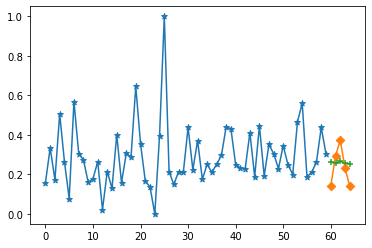

In [25]:
draw_inference(pred_model, test_x[2], test_y[2])

1/1 [==============================] - 0s 44ms/step
(1, 5)


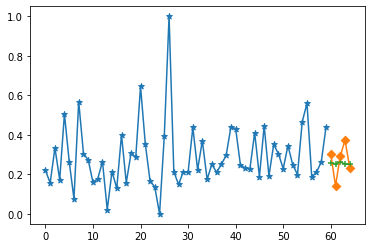

In [26]:
draw_inference(pred_model, test_x[1], test_y[1])

In [27]:
test_x.shape

(8, 60, 33)

1/1 [==============================] - 0s 38ms/step
(1, 5)


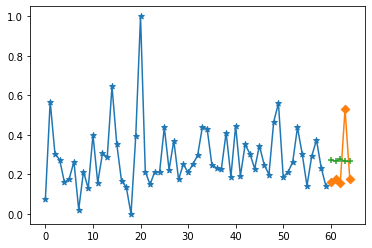

In [28]:
draw_inference(pred_model, test_x[7], test_y[7])